In [1]:
%matplotlib inline

Analyze Visium H&E data
=======================

This tutorial shows how to apply Squidpy for the analysis of Visium
spatial transcriptomics data.

The dataset used here consists of a Visium slide of a coronal section of
the mouse brain. The original dataset is publicly available at the 10x
genomics [dataset
portal](https://support.10xgenomics.com/spatial-gene-expression/datasets)
. Here, we provide a pre-processed dataset, with pre-annotated clusters,
in AnnData format and the tissue image in squidpy.im.ImageContainer
format.

A couple of notes on pre-processing:

-   The pre-processing pipeline is the same as the one shown in the
    original [Scanpy
    tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html)
    .
-   The cluster annotation was performed using several resources, such
    as the [Allen Brain
    Atlas](http://mouse.brain-map.org/experiment/thumbnails/100048576?image_type=atlas)
    , the [Mouse Brain gene expression
    atlas](http://mousebrain.org/genesearch.html) from the Linnarson lab
    and this recent
    [pre-print](https://www.biorxiv.org/content/10.1101/2020.07.24.219758v1)
    .

Import packages & data
----------------------

To run the notebook locally, create a conda environment as *conda create
-f environment.yml* using this
[environment.yml](https://github.com/theislab/squidpy_notebooks/blob/master/environment.yml)


In [2]:
import scanpy as sc
import anndata as ad
import squidpy as sq

import numpy as np
import pandas as pd

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.6.2 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 leidenalg==0.8.3
squidpy==1.0.0


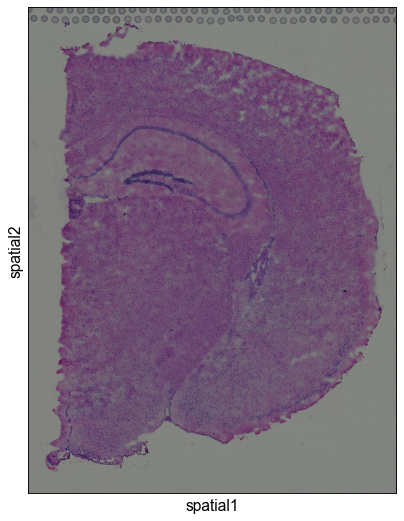

In [21]:
sc.pl.spatial(adata)

First, let's visualize cluster annotation in spatial context with
scanpy.pl.spatial.


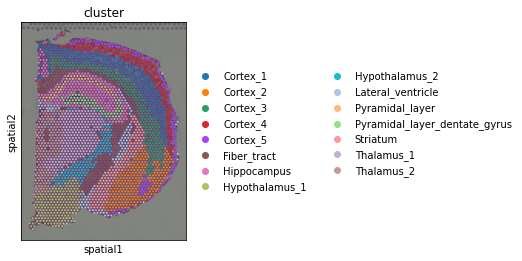

In [3]:
sc.pl.spatial(adata, color="cluster")

Image features
==============

Visium datasets contain high-resolution images of the tissue that was
used for the gene extraction. Using the function
squidpy.im.calculate\_image\_features you can calculate image features
for each Visium spot and create a `obs x features` matrix in `adata`
that can then be analyzed together with the `obs x gene` gene expression
matrix.

By extracting image features we are aiming to get both similar and
complementary information to the gene expression values. Similar
information is for example present in the case of a tissue with two
different cell types whose morphology is different. Such cell type
information is then contained in both the gene expression values and the
tissue image features.

Squidpy contains several feature extractors and a flexible pipeline of
calculating features of different scales and sizes. There are several
detailed examples of how to use squidpy.im.calculate\_image\_features.
sphx\_glr\_auto\_examples\_image\_compute\_features.py provides a good
starting point for learning more.

Here, we will extract summary features at different crop sizes and
scales to allow the calculation of multi-scale features and segmentation
features. For more information on the summary features, also refer to
sphx\_glr\_auto\_examples\_image\_compute\_summary\_features.py.


In [8]:
adata.obsm

AxisArrays with keys: X_pca, X_umap, spatial

In [9]:
# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img,
        features="summary",
        key_added=feature_name,
        n_jobs=1,
        scale=scale,
    )


# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f], axis="columns"
)
# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(adata.obsm["features"].columns)

  0%|          | 0/2688 [00:00<?, ?/s]

c:\users\sai\anaconda3\envs\squidpy\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


  0%|          | 0/2688 [00:00<?, ?/s]

In [11]:
adata.obsm['features_summary_scale1.0']

,summary_ch-0_quantile-0.9,summary_ch-0_quantile-0.5,summary_ch-0_quantile-0.1,summary_ch-0_mean,summary_ch-0_std,summary_ch-1_quantile-0.9,summary_ch-1_quantile-0.5,summary_ch-1_quantile-0.1,summary_ch-1_mean,summary_ch-1_std,summary_ch-2_quantile-0.9,summary_ch-2_quantile-0.5,summary_ch-2_quantile-0.1,summary_ch-2_mean,summary_ch-2_std
AAACAAGTATCTCCCA-1,132.0,111.0,77.0,107.571140,21.767668,102.0,79.0,54.0,78.586668,19.153915,138.0,111.0,88.0,112.461305,19.733864
AAACAATCTACTAGCA-1,140.0,111.0,80.0,109.815175,25.047208,87.0,60.0,39.0,61.846105,19.495044,135.0,108.0,84.0,108.806211,19.869577
AAACACCAATAACTGC-1,132.0,116.0,89.0,112.421285,19.088559,109.0,91.0,67.0,89.382780,16.884106,130.0,117.0,97.0,114.699912,13.826571
AAACAGAGCGACTCCT-1,136.0,116.0,93.0,115.085217,17.450778,115.0,82.0,58.0,84.919202,22.004344,137.0,113.0,89.0,113.176998,18.714021
AAACCGGGTAGGTACC-1,137.0,112.0,83.0,110.426840,21.210674,103.0,78.0,54.0,78.434920,19.046626,133.0,113.0,92.0,112.872996,15.922622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,135.0,107.0,45.0,98.505365,33.255413,104.0,74.0,33.0,71.122964,26.024651,143.0,111.0,74.0,109.601818,26.373283
TTGTTTCACATCCAGG-1,139.0,107.0,64.0,104.259942,28.099418,112.0,81.0,49.0,80.879687,24.025899,140.0,113.0,84.0,112.594622,21.763193
TTGTTTCATTAGTCTA-1,135.0,111.0,73.0,107.579220,24.471029,107.0,81.0,54.0,80.455372,20.784933,134.0,114.0,89.0,112.461305,18.158389
TTGTTTCCATACAACT-1,136.0,110.0,77.0,107.720490,23.502833,99.0,73.0,49.0,73.409923,19.286326,133.0,112.0,88.0,110.888272,18.042013


In [10]:
print(adata.obsm['features'].shape)
print(adata.obsm['features_summary_scale1.0'].shape)
print(adata.obsm['features_summary_scale2.0'].shape)

(2688, 30)
(2688, 15)
(2688, 15)


We can use the extracted image features to compute a new cluster
annotation. This could be useful to gain insights in similarities across
spots based on image morphology.


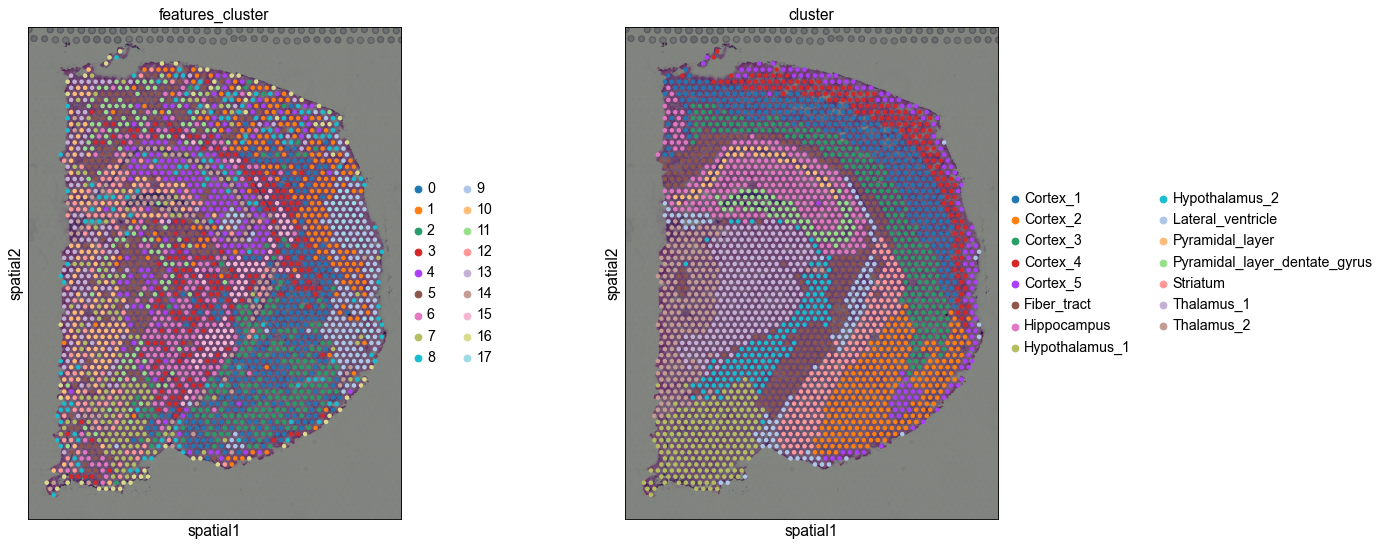

In [18]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None):
    """Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]


# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

# compare feature and gene clusters
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(adata, color=["features_cluster", "cluster"])

Comparing gene and feature clusters, we notice that in some regions,
they look very similar, like the cluster *Fiber\_tract*, or clusters
around the Hippocampus seems to be roughly recapitulated by the clusters
in image feature space. In others, the feature clusters look different,
like in the cortex, where the gene clusters show the layered structure
of the cortex, and the features clusters rather seem to show different
regions of the cortex.

This is only a simple, comparative analysis of the image features, note
that you could also use the image features to e.g. compute a common
image and gene clustering by computing a shared neighbors graph (for
instance on concatenated PCAs on both feature spaces).


Spatial statistics and graph analysis
=====================================

Similar to other spatial data, we can investigate spatial organization
by leveraging spatial and graph statistics in Visium data.

Neighborhood enrichment
-----------------------

Computing a neighborhood enrichment can help us identify spots clusters
that share a common neighborhood structure across the tissue. We can
compute such score with the following function:
squidpy.gr.nhood\_enrichment. In short, it's an enrichment score on
spatial proximity of clusters: if spots belonging to two different
clusters are often close to each other, then they will have a high score
and can be defined as being *enriched*. On the other hand, if they are
far apart, and therefore are seldom a neighborhood, the score will be
low and they can be defined as *depleted*. This score is based on a
permutation-based test, and you can set the number of permutations with
the `n_perms` argument (default is 1000).

Since the function works on a connectivity matrix, we need to compute
that as well. This can be done with squidpy.gr.spatial\_neighbors.
Please see
sphx\_glr\_auto\_examples\_graph\_compute\_spatial\_neighbors.py for
more details of how this function works.

Finally, we'll directly visualize the results with
squidpy.pl.nhood\_enrichment.


  0%|          | 0/1000 [00:00<?, ?/s]

c:\users\sai\anaconda3\envs\squidpy\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


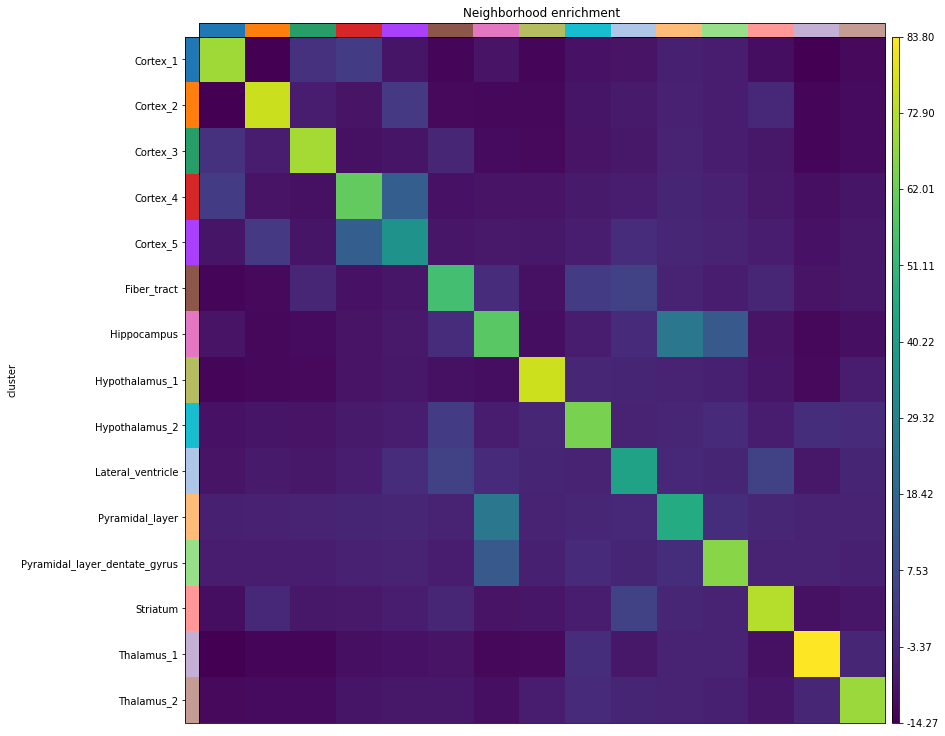

In [4]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="cluster")
sq.pl.nhood_enrichment(adata, cluster_key="cluster")

Given the spatial organization of the mouse brain coronal section, not
surprisingly we find high neighborhood enrichment the Hippocampus
region: *Pyramidal\_layer\_dentate\_gyrus* and *Pyramidal\_layer*
clusters seems to be often neighbors with the larger *Hippocampus*
cluster.


Co-occurrence across spatial dimensions
=======================================

In addition to the neighbor enrichment score, we can visualize cluster
co-occurrence in spatial dimensions. This is a similar analysis of the
one presented above, yet it does not operate on the connectivity matrix,
but on the original spatial coordinates. The co-occurrence score is
defined as:

$$\frac{p(exp|cond)}{p(exp)}$$

where $p(exp|cond)$ is the conditional probability of observing a
cluster $exp$ conditioned on the presence of a cluster $cond$, whereas
$p(exp)$ is the probability of observing $exp$ in the radius size of
interest. The score is computed across increasing radii size around each
observation (i.e. spots here) in the tissue.

We are gonna compute such score with squidpy.gr.co\_occurrence and set
the cluster annotation for the conditional probability with the argument
`clusters`. Then, we visualize the results with
squidpy.pl.co\_occurrence.


  0%|          | 0/1 [00:00<?, ?/s]

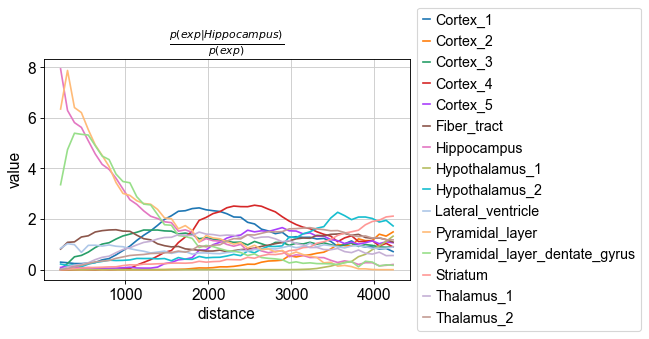

In [23]:
sq.gr.co_occurrence(adata, cluster_key="cluster")
sq.pl.co_occurrence(
    adata,
    cluster_key="cluster",
    clusters="Hippocampus",
    figsize=(8, 4),
)

The result largely recapitulates the previous analysis: the
*Pyramidal\_layer* cluster seem to co-occur at short distances with the
larger *Hippocampus* cluster. It should be noted that the distance units
are given in pixels of the Visium `source_image`, and corresponds to the
same unit of the spatial coordinates saved in `adata.obsm["spatial"]`.


Ligand-receptor interaction analysis
====================================

We are continuing the analysis showing couple of feature-level methods
that are very relevant for the analysis of spatial molecular data. For
instance, after quantification of cluster co-occurrence, we might be
interested in finding molecular instances that could potentially drive
cellular communication. This naturally translates in a ligand-receptor
interaction analysis. In Squidpy, we provide a fast re-implementation
the popular method CellPhoneDB cellphonedb
([code](https://github.com/Teichlab/cellphonedb) ) and extended its
database of annotated ligand-receptor interaction pairs with the popular
database *Omnipath* omnipath. You can run the analysis for all clusters
pairs, and all genes (in seconds, without leaving this notebook), with
squidpy.gr.ligrec. Furthermore, we'll directly visualize the results,
filtering out lowly-expressed genes (with the `means_range` argument)
and increasing the threshold for the adjusted p-value (with the `alpha`
argument). We'll also subset the visualization for only one source
group, the *Hippocampus* cluster, and two target groups,
*Pyramidal\_layer\_dentate\_gyrus* and *Pyramidal\_layer* cluster.


  0%|          | 0.00/8.94M [00:00<?, ?B/s]

c:\users\sai\anaconda3\envs\squidpy\lib\site-packages\omnipath\_core\requests\interactions\_interactions.py:377: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  return cls(include, exclude=exclude)._get(**kwargs)
c:\users\sai\anaconda3\envs\squidpy\lib\site-packages\omnipath\_core\requests\_utils.py:155: FutureWarning: The default value of regex will change from True to False in a future version.
  _split_unique_join(data.str.replace(r"[-\w]*:?(\d+)", r"\1")), func=func


  0%|          | 0.00/1.39M [00:00<?, ?B/s]

  0%|          | 0.00/2.60M [00:00<?, ?B/s]

  0%|          | 0/100 [00:00<?, ?permutation/s]

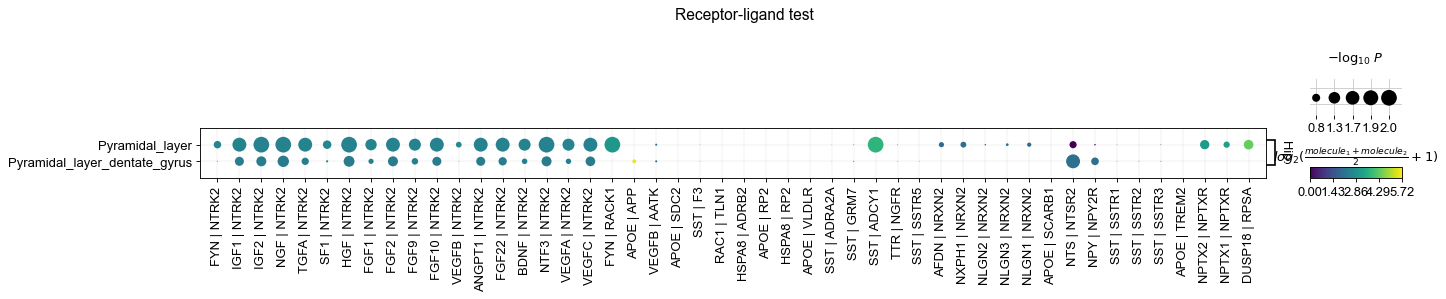

In [24]:
sq.gr.ligrec(
    adata,
    n_perms=100,
    cluster_key="cluster",
)
sq.pl.ligrec(
    adata,
    cluster_key="cluster",
    source_groups="Hippocampus",
    target_groups=["Pyramidal_layer", "Pyramidal_layer_dentate_gyrus"],
    means_range=(3, np.inf),
    alpha=1e-4,
    swap_axes=True,
)

The dotplot visualization provides an interesting set of candidate
ligand-receptor annotation that could be involved in cellular
interactions in the Hippocampus. A more refined analysis would be for
instance to integrate these results with the results of a deconvolution
method, to understand what's the proportion of single-cell cell types
present in this region of the tissue.


Spatially variable genes with Moran's I
=======================================

Finally, we might be interested in finding genes that show spatial
patterns. There are several methods that aimed at address this
explicitly, based on point processes or Gaussian process regression
framework:

-   *SPARK* -
    [paper](https://www.nature.com/articles/s41592-019-0701-7#Abs1),
    [code](https://github.com/xzhoulab/SPARK).
-   *Spatial DE* - [paper](https://www.nature.com/articles/nmeth.4636),
    [code](https://github.com/Teichlab/SpatialDE).
-   *trendsceek* - [paper](https://www.nature.com/articles/nmeth.4634),
    [code](https://github.com/edsgard/trendsceek).
-   *HMRF* - [paper](https://www.nature.com/articles/nbt.4260),
    [code](https://bitbucket.org/qzhudfci/smfishhmrf-py).

Here, we provide a simple approach based on the well-known [Moran's I
statistics](https://en.wikipedia.org/wiki/Moran%27s_I) which is in fact
used also as a baseline method in the spatially variable gene papers
listed above. The function in Squidpy is called squidpy.gr.moran, and
returns both test statistics and adjusted p-values in
anndata.AnnData.var slot. For time reasons, we will evaluate a subset of
the highly variable genes only.


In [5]:
genes = adata[:, adata.var.highly_variable].var_names.values[0:1000]
sq.gr.moran(
    adata,
    genes=genes,
    n_perms=100,
    n_jobs=1,
)

c:\users\sai\anaconda3\envs\squidpy\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


  0%|          | 0/1000 [00:00<?, ?/s]

The results are saved in `adata.uns['moranI']` slot. Genes have already
been sorted by Moran's I statistic.


In [6]:
adata.uns["moranI"].head(10)

,I,pval_sim,VI_sim,pval_sim_fdr_bh
Olfm1,0.763291,0.0,0.000119,0.0
Plp1,0.747660,0.0,0.000139,0.0
Itpka,0.727076,0.0,0.000109,0.0
Snap25,0.720987,0.0,0.000089,0.0
Nnat,0.708637,0.0,0.000108,0.0
Ppp3ca,0.693320,0.0,0.000109,0.0
Chn1,0.684957,0.0,0.000118,0.0
Mal,0.679775,0.0,0.000132,0.0
Tmsb4x,0.676719,0.0,0.000129,0.0
Cldn11,0.674110,0.0,0.000139,0.0


We can select few genes and visualize their expression levels in the
tissue with scanpy.pl.spatial


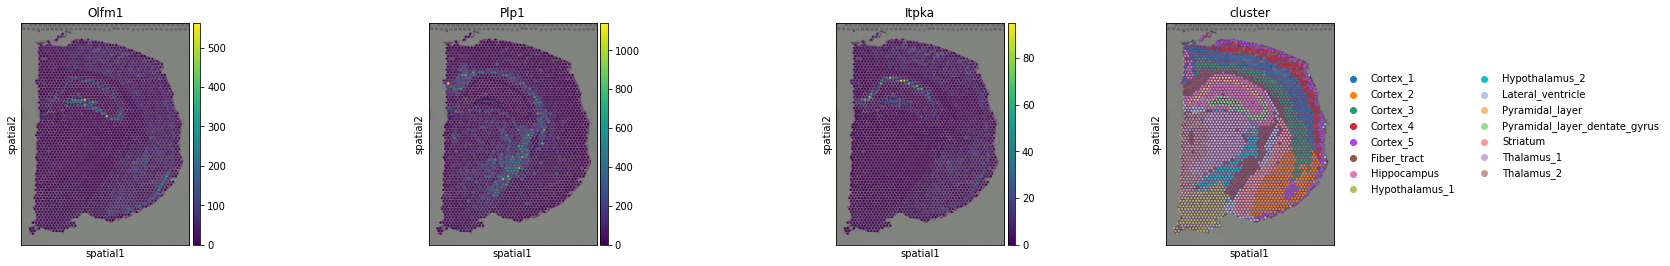

In [7]:
sc.pl.spatial(adata, color=["Olfm1", "Plp1", "Itpka", "cluster"])

Interestingly, some of these genes seems to be related to the
*pyramidal* layers and the *fiber tract*.
